**Name:** \_\_\_\_\_

**EID:** \_\_\_\_\_

# Tutorial 5: Image Segmentation using Clustering

In this tutorial you will use clustering algorithms to generate a segmentation of an image.  An image segmentation is a separation of an image into regions belonging to distinct objects.
First we need to initialize Python.  Run the below cell.

In [1]:
%matplotlib inline
import IPython.core.display
# setup output image format (Chrome works best)
# jpg is better for images
IPython.core.display.set_matplotlib_formats("jpg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import glob
import os
import csv
import string
import skimage.io
import skimage.color
import skimage.util
random.seed(100)

C:\Users\HAOYCH~1\AppData\Local\Temp/ipykernel_13688/1910902242.py:5: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.core.display.set_matplotlib_formats("jpg")


## 1. Loading Data and Pre-processing
Next we need to load the data.  Download `imgdb.zip`, and unzip it in the same directory as this ipynb file.  Then run the following cell to load the image data.

In [2]:
filelist = glob.glob('imgdb/jpg/*.jpg')
# https://drive.google.com/drive/folders/17hZsPa6p8KtJLZjwJFIMiEECa4Bt54EY?usp=drive_link
gtpath   = 'imgdb/gtruth/'
if len(filelist) == 0:
    warn.error("Could not find imgdb directory!  " +
               "Make sure you put it here: " + os.getcwd() )
else:
    imgdata = []
    gtdata  = []

    # load image data
    for f in filelist:
        # load image - byte [0 to 255]
        img = skimage.io.imread(f)

        (fdir1, fname)  = os.path.split(f)

        # load GT segmentation (non-consecutive integers)
        gname = gtpath + fname[:-4] + "-gt.png"
        gtimg = skimage.io.imread(gname)

        # convert to consecutive integers
        cl = unique(gtimg)
        gtimg0 = gtimg.copy().astype(float64)
        for i in range(len(cl)):
            gtimg0[gtimg==cl[i]] = i

        imgdata.append(img)
        gtdata.append(gtimg0)
print(len(imgdata))

14


There are 14 images.  Each image also has a ground-truth segmentation that was created by a human annotation.  Here is an example:

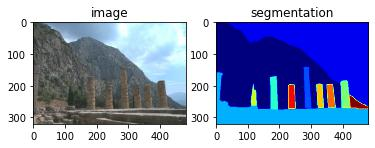

In [3]:
plt.subplot(1,2,1)
plt.imshow(imgdata[6], aspect='equal')# change the image: image[0-13]
plt.title('image')
plt.subplot(1,2,2)
plt.imshow(gtdata[6], aspect='equal', cmap='jet')
plt.title('segmentation');

## 2. Clustering with Color Features
To segment an image, we will extract features from each pixel location.  Then, we cluster the extracted features into groups.  Pixel location that are clustered into the same group form a segment.

For the features, we will use the "Lab" colorspace, rather than the RGB colors.  Also, we will ignore the "L" feature, which is brightness, resulting in a 2-dimensional color feature space (a, b). Here are a few helper functions:
- getfeatures(): Extract Lab features along a regular grid on the image;
- labels2seg(): Convert cluster labels into a segmentation image;
- colorsegms(): Color a segmentation image using colors from the original image.

In [4]:
def getfeatures(img, segm=None, stepsize=7, use_loc = False):
    """
    getfeatures - extract features from an image
     [X, Y, L] = getfeatures(img, stepsize)
     INPUT
     img      - the image   [type = np.ndarray or Image]
     segm     - the gt segmentation (optional)
     stepsize - window stepsize
     OUTPUT
      X   - the features: each row is a feature vector  [type = np.ndarray]
      Y   - the GT segment labels for each feature (if segm is provided)
      L   - dictionary containing location information of each feature
    """
    winsize = 7 # ensure it is an odd number
    if stepsize > winsize:
        raise Exception('stepsize larger than window size')
    # convert to LAB
    yimg = skimage.color.rgb2lab(img)

    offset = floor((winsize-1)/2)
    sy,sx, sc = img.shape

    if use_loc:
        Xdim = 4
    else:
        Xdim = 2

    # extract window patches with stepsize
    patches = skimage.util.view_as_windows(yimg, (winsize, winsize, 3), step=stepsize)
    psize = patches.shape

    # get coordinates of windows
    rangex = arange(psize[1])*stepsize + offset
    rangey = arange(psize[0])*stepsize + offset

    X = zeros((psize[0] * psize[1], Xdim));

    if segm is None:
        Y = None
    else:
        Y = zeros((X.shape[0],))

    i = 0
    for x in range(psize[1]):
        for y in range(psize[0]):
            myu = mean(patches[y,x,0,:,:,1].flatten())
            myv = mean(patches[y,x,0,:,:,2].flatten())
            myy = int(rangey[y])
            myx = int(rangex[x])

            if use_loc:
                X[i,:] = [myu, myv, myx, myy]
            else:
                X[i,:] = [myu, myv]

            if Y is not None:
                Y[i] = segm[myy, myx]

            i = i + 1

    L = {'rangex':rangex, 'rangey':rangey, 'offset':offset, 'sx':sx, 'sy':sy, \
         'stepsize':stepsize, 'winsize':winsize}
    return X, Y, L

def labels2seg(Y,L):
    """
    labels2segm - form a segmentation image using cluster labels
    segm = labels2segm(Y, L)
    Y - cluster labels for each location
    L - location dictionary from getfeatures
    segm - output segmentation image
    """
    segm = zeros((L['sy'], L['sx']))
    # <= offset if floor((winsize-1)/2)>= floor(stepsize/2)
    rstep = int(floor(L['stepsize']/2.0))
    stepbox = range(-rstep, L['stepsize'] - rstep)
    rx = asarray(L['rangex'], dtype=int) + int(L['offset'])
    ry = asarray(L['rangey'], dtype=int) + int(L['offset'])
    Y_reshaped = Y.reshape((ry.size, rx.size),order='F')
    for i in stepbox:
        for j in stepbox:
            segm[ix_(ry + j, rx + i)] = Y_reshaped
    ## Now fil in the borders if they are missing
    minx = min(rx) + stepbox[0] - 1
    maxx = max(rx) + stepbox[-1] + 1
    miny = min(ry) + stepbox[0] - 1
    maxy = max(ry) + stepbox[-1] + 1

    if 0 <= minx:
        ## fill in left edge
        segm[:, 0:minx+1] = segm[:,minx+1].reshape((-1,1))
    if maxx < L['sx']:
        ## fill in right edge
        segm[:,maxx:] = segm[:,maxx-1].reshape((-1,1))
    if 0 < miny:
        ## fill in top edge
        segm[0:miny+1,:] = segm[miny+1,:].reshape((1,-1))
    if maxy < L['sy']:
        ## fill in bottom edge
        segm[maxy:,:] = segm[maxy-1,:].reshape((1,-1))
    return segm

def colorsegms(segm, img):
    """
    colorsegm - color a segmentation based on the image
    csegm = colorsegm(segm, img)
    segm = the segmentation image  [type = np.ndarray]
    img = the original image    [type = np.ndarray (or Image)]
    csegm = the colored segmentation -- each segment is colored based on the
            average pixel color within the segment.
    """
    img = asarray(img).copy()
    if segm.shape[0:2] != img.shape[0:2]:
        raise Exception('The shape of segmentation and image are not consistent')
    rimg, gimg, bimg = img[:,:,0], img[:,:,1], img[:,:,2]
    for i in range(0, int(max(segm.flatten())) + 1):
        # assume label starts from 1
        ind = (segm == i)
        rimg[ind] = mean(rimg[ind].flatten())
        gimg[ind] = mean(gimg[ind].flatten())
        bimg[ind] = mean(bimg[ind].flatten())
    # handle outliers from DBSCAN
    ind = (segm == -1)
    rimg[ind] = 0
    gimg[ind] = 0
    bimg[ind] = 0
    return img

Next, we use the `getfeatures` function to extract features from an image.  `X` contains the feature vectors. `L` contains information about where each features was extracted, which is used later generate the segmentation.

(3060, 2)


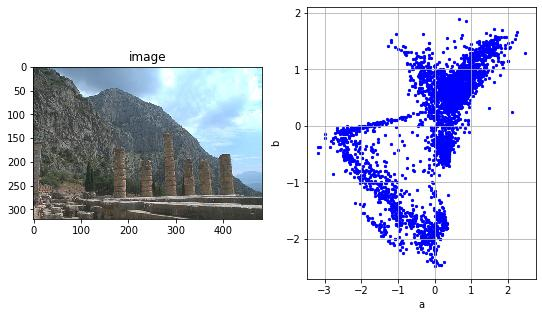

In [5]:
# image to use
img = imgdata[6]
gt  = gtdata[6]

# extract features, each row is a feature vector
Xo,Ytrue, L = getfeatures(img, gt)
print(Xo.shape)

# normalize features
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(Xo)

# view the image
plt.figure(figsize=(9,5))
plt.subplot(1,2,1)
plt.imshow(img, interpolation='nearest')
plt.title("image")

# view the features
plt.subplot(1,2,2)
#plt.scatter(X[:,0], X[:,1], c='b', s=5, edgecolor='')
plt.scatter(X[:,0], X[:,1], c='b', s=5, edgecolor=None)
plt.ylabel('b'); plt.xlabel('a'); plt.grid(True)

Here is the segmented image, with the segment labels shown as colors.  The goal is to recoever these labels using clustering.

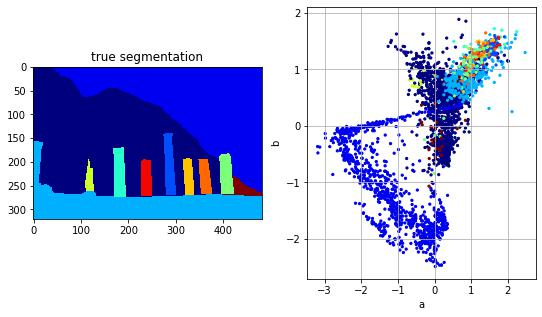

In [6]:
# view the image
plt.figure(figsize=(9,5))

plt.subplot(1,2,1)
plt.imshow(gt, interpolation='nearest', cmap='jet')
plt.title("true segmentation")

# view the features
plt.subplot(1,2,2)
plt.scatter(X[:,0], X[:,1], c=Ytrue, s=5, edgecolor=None, cmap='jet')
plt.ylabel('b'); plt.xlabel('a'); plt.grid(True)

Now use a clustering algorithm to group the data into **5** clusters.

In [7]:
### INSERT YOUR CODE HERE
## HINT
# 1. cluster.KMeans(n_clusters=5 , random_state=)

In [8]:
### INSERT YOUR CODE HERE
K = 5

km = cluster.KMeans(n_clusters=K, random_state=123)
Y = km.fit_predict(X)


C:\Users\haoychen3\Anaconda3\envs\test\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Once you have the cluster labels (Y), use the below code to generate the segmentation image and view it.  You can also view the scatter plot with `showscatter`.

In [9]:
def showsegm(segm, img):
    "show a segmentation"

    # fill segmentation with colors from the image
    csegm = colorsegms(segm, img)

    # view the images, segmentation, and ground-truth
    plt.figure(figsize=(9,6))
    plt.subplot(2,2,1)
    plt.imshow(img, interpolation='nearest')
    plt.title('image')
    plt.subplot(2,2,2)
    plt.imshow(segm, interpolation='nearest', cmap='jet')
    plt.title('segmentation')
    plt.subplot(2,2,3)
    plt.imshow(csegm, interpolation='nearest')
    plt.title('segmentation w/ color')
    plt.subplot(2,2,4)
    plt.imshow(gt, interpolation='nearest', cmap='jet')
    plt.title("ground truth")

    return segm

def showscatter(X,Y):
    "show a scatter plot of clusters"

    if X.shape[1] == 2:
        plt.figure()
        plt.scatter(X[:,0], X[:,1], c=Y, s=5, edgecolor=None, cmap='jet')
        plt.grid(True)
        plt.xlabel('a')
        plt.ylabel('b')
    else:
        plt.figure(figsize=(9,9))

        plt.subplot(2,2,1)
        plt.scatter(X[:,0], X[:,1], c=Y, s=5, edgecolor=None, cmap='jet')
        plt.xlabel('a'); plt.ylabel('b'); plt.grid(True)

        plt.subplot(2,2,2)
        plt.scatter(X[:,2], X[:,3], c=Y, s=5, edgecolor=None, cmap='jet')
        plt.xlabel('x-pos'); plt.ylabel('y-pos'); plt.grid(True)

        plt.subplot(2,2,3)
        plt.scatter(X[:,2], X[:,0], c=Y, s=5, edgecolor=None, cmap='jet')
        plt.xlabel('x-pos'); plt.ylabel('a'); plt.grid(True)

        plt.subplot(2,2,4)
        plt.scatter(X[:,3], X[:,1], c=Y, s=5, edgecolor=None, cmap='jet')
        plt.xlabel('y-pos'); plt.ylabel('b'); plt.grid(True)

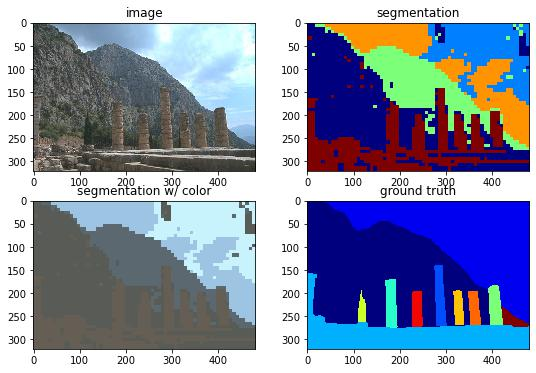

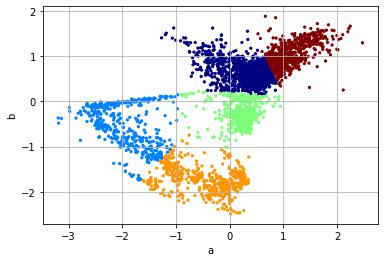

In [10]:
# convert cluster labels to a segmentation image
segm = labels2seg(Y, L)

# show the segmentation
showsegm(segm, img)

# show the scatter plot
showscatter(X,Y)

Next we evaluate the segmentation with the ground-truth provided by a human annotator.  We cannot just check that the cluster assignments for each pixel are the same, since the cluster indices can be permuted.  We will use the [Adjusted Rand Index (ARI)](https://en.wikipedia.org/wiki/Rand_index#Adjusted_Rand_index), which calculates how often a pair of pixels is assigned correctly to the same cluster or not.  Use the below code to calculate the [ARI](https://scikit-learn.org/stable/modules/clustering.html#adjusted-rand-score). Higher values are better, and the maximum value is 1.

In [11]:
# calculate ARI
ari = metrics.adjusted_rand_score(gt.flatten(), segm.flatten())
print("ARI =",ari)

ARI = 0.38243942445896


Let us iterate K-means and Gaussian Mixture Models with different cluster number to get the best segmentation as measured by ARI.

In [12]:
### INSERT YOUR CODE HERE
## HINT
# 1. Ks  = [2, 3, 4, 5, 6, 7, 8, 9, 10] #cluster numbers
# 2. models = [
#    [cluster.KMeans(random_state=123, n_jobs=-1), {'n_clusters':Ks}],
#    [mixture.GaussianMixture(covariance_type='diag', random_state=444), {'n_components': Ks}],
#  ]
# 3. model_selection.ParameterGrid() # iterate each model

In [13]:
### INSERT YOUR CODE HERE
Ks = [2,3,4,5,6,7,8,9,10]

models = [
    [cluster.KMeans(random_state=123), {'n_clusters':Ks}],
    [mixture.GaussianMixture(covariance_type='diag', random_state=444), {'n_components': Ks}],
]

results = []
for i,modelpack in enumerate(models):

    # get parameters
    #pgrid = grid_search.ParameterGrid(modelpack[1])
    pgrid = model_selection.ParameterGrid(modelpack[1])


    # get model
    model = modelpack[0]
    name = model.__class__.__name__
    print(name)

    myinfo = {'name':name}
    bestari = -1
    for p in pgrid:
        model.set_params(**p)

        if hasattr(model, 'fit_predict'):
            Y = model.fit_predict(X)
        else:
            model.fit(X)
            Y = model.predict(X)
        segm = labels2seg(Y, L)
        ari = metrics.adjusted_rand_score(gt.flatten(), segm.flatten())

        print(ari, "for", p)
        if (ari>bestari):
            bestari = ari
            myinfo['param'] = p
            myinfo['segm']  = segm
            myinfo['ari']   = ari
            myinfo['Y']     = Y

    # save best result
    results.append(myinfo)

KMeans


C:\Users\haoychen3\Anaconda3\envs\test\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.4455298683056748 for {'n_clusters': 2}


C:\Users\haoychen3\Anaconda3\envs\test\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.32522845067553824 for {'n_clusters': 3}


C:\Users\haoychen3\Anaconda3\envs\test\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.5357692889856138 for {'n_clusters': 4}


C:\Users\haoychen3\Anaconda3\envs\test\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.38243942445896 for {'n_clusters': 5}


C:\Users\haoychen3\Anaconda3\envs\test\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.334097663908754 for {'n_clusters': 6}


C:\Users\haoychen3\Anaconda3\envs\test\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.2580349833877121 for {'n_clusters': 7}


C:\Users\haoychen3\Anaconda3\envs\test\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.3045227447146036 for {'n_clusters': 8}


C:\Users\haoychen3\Anaconda3\envs\test\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.2784807523559136 for {'n_clusters': 9}


C:\Users\haoychen3\Anaconda3\envs\test\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.2708645015622179 for {'n_clusters': 10}
GaussianMixture
0.3718445548235134 for {'n_components': 2}
0.3320234360598012 for {'n_components': 3}
0.5338132637758952 for {'n_components': 4}
0.3405480083649792 for {'n_components': 5}
0.28947296214070445 for {'n_components': 6}
0.26726064923776527 for {'n_components': 7}
0.2365812580297477 for {'n_components': 8}
0.21478976943196762 for {'n_components': 9}
0.25742172689620674 for {'n_components': 10}


In [14]:
for L in results:
    print(L['name'])
    print(L['param'])
    print(L['ari'])

KMeans
{'n_clusters': 4}
0.5357692889856138
GaussianMixture
{'n_components': 4}
0.5338132637758952


----
KMeans
{'n_clusters': 4}


<Figure size 432x288 with 0 Axes>

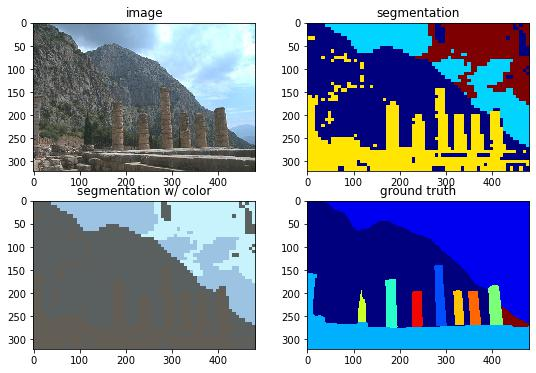

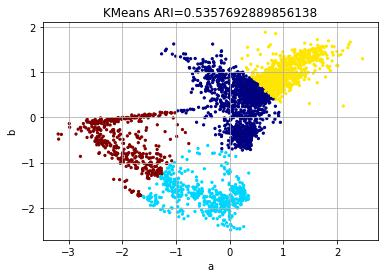

----
GaussianMixture
{'n_components': 4}


<Figure size 432x288 with 0 Axes>

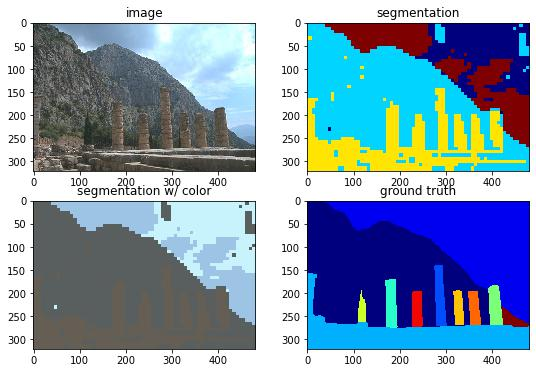

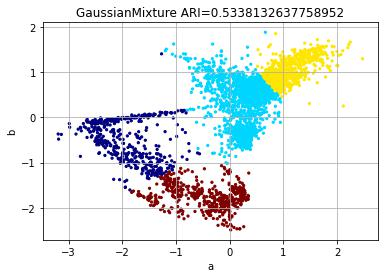

In [15]:
for L in results:
    print('----')
    print(L['name'])
    print(L['param'])

    plt.figure()
    # show the segmentation
    showsegm(L['segm'], img)

    # show the scatter plot
    showscatter(X,L['Y'])
    plt.title(L['name'] + " ARI=" + str(L['ari']))
    plt.show()

## 3. Color and Position Features
You may notice that the segmentation is not spatially smooth. There are some "loner" pixels that are not the same cluster as the surrounding pixels.  This is because we are only clustering color.  One way to fix this is to include the (x,y) coordinate of the pixel as part of the feature vector.  This way, clusters will have pixels that are spatially close together.

The below code extracts a 4-dimensional feature vector, where the first 2 features are the color channels and the last 2 features are the position.

In [16]:
# extract features with location
Xo,Ytrue,L = getfeatures(img, gt, use_loc=True)
print(Xo.shape)

# normalize features
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(Xo)

# rescale position features
# larger values emphasize clustering by position more
X[:,2:4] *= 0.5

(3060, 4)


Here are plots of the 4 features.

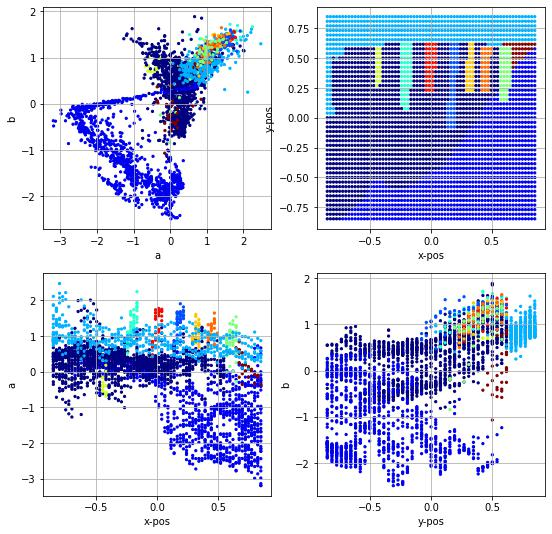

In [17]:
showscatter(X, Ytrue)

Run clustering algorithms on the 4-dimensional data.  Try different algorithms and parameters to get the best ARI.

In [18]:
### INSERT YOUR CODE HERE

In [19]:
### INSERT YOUR CODE HERE

Ks = [2,3,4,5,6,7,8,9,10]


models = [
    [cluster.KMeans(random_state=123), {'n_clusters':Ks}],
    [mixture.GaussianMixture(covariance_type='diag', random_state=444), {'n_components': Ks}],
]

results2 = []
for i,modelpack in enumerate(models):

    # get parameters
    pgrid =  model_selection.ParameterGrid(modelpack[1])

    # get model
    model = modelpack[0]
    name = model.__class__.__name__
    print(name)

    myinfo = {'name':name}
    bestari = -1
    for p in pgrid:
        model.set_params(**p)

        if hasattr(model, 'fit_predict'):
            Y = model.fit_predict(X)
        else:
            model.fit(X)
            Y = model.predict(X)
        segm = labels2seg(Y, L)
        ari = metrics.adjusted_rand_score(gt.flatten(), segm.flatten())

        print(ari, "for", p)
        if (ari>bestari):
            bestari = ari
            myinfo['param'] = p
            myinfo['segm']  = segm
            myinfo['ari']   = ari
            myinfo['Y']     = Y

    # save best result
    results2.append(myinfo)

KMeans


C:\Users\haoychen3\Anaconda3\envs\test\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.4448981957389038 for {'n_clusters': 2}


C:\Users\haoychen3\Anaconda3\envs\test\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.24344371892222655 for {'n_clusters': 3}


C:\Users\haoychen3\Anaconda3\envs\test\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.6037546695140711 for {'n_clusters': 4}


C:\Users\haoychen3\Anaconda3\envs\test\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.44408312152015694 for {'n_clusters': 5}


C:\Users\haoychen3\Anaconda3\envs\test\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.3975152042010202 for {'n_clusters': 6}


C:\Users\haoychen3\Anaconda3\envs\test\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.32540701131144023 for {'n_clusters': 7}


C:\Users\haoychen3\Anaconda3\envs\test\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.31485553841965147 for {'n_clusters': 8}


C:\Users\haoychen3\Anaconda3\envs\test\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.28888330441887355 for {'n_clusters': 9}


C:\Users\haoychen3\Anaconda3\envs\test\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.2732376001376492 for {'n_clusters': 10}
GaussianMixture
0.3365620250324674 for {'n_components': 2}
0.405275876668192 for {'n_components': 3}
0.4713637203481415 for {'n_components': 4}
0.43011435995192787 for {'n_components': 5}
0.2822972585053091 for {'n_components': 6}
0.3330567684486653 for {'n_components': 7}
0.3576327596263941 for {'n_components': 8}
0.341625823221834 for {'n_components': 9}
0.3100990870183742 for {'n_components': 10}


In [20]:
for L in results2:
    print(L['name'])
    print(L['param'])
    print(L['ari'])

KMeans
{'n_clusters': 4}
0.6037546695140711
GaussianMixture
{'n_components': 4}
0.4713637203481415


------
KMeans
{'n_clusters': 4}


<Figure size 432x288 with 0 Axes>

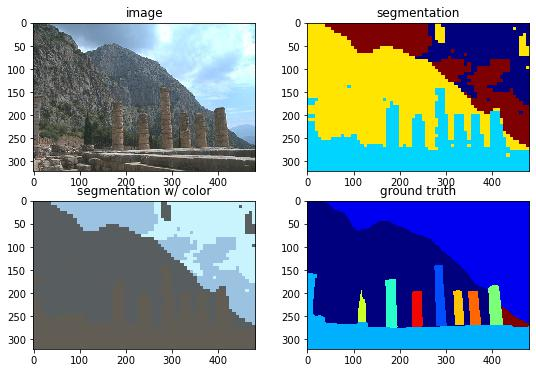

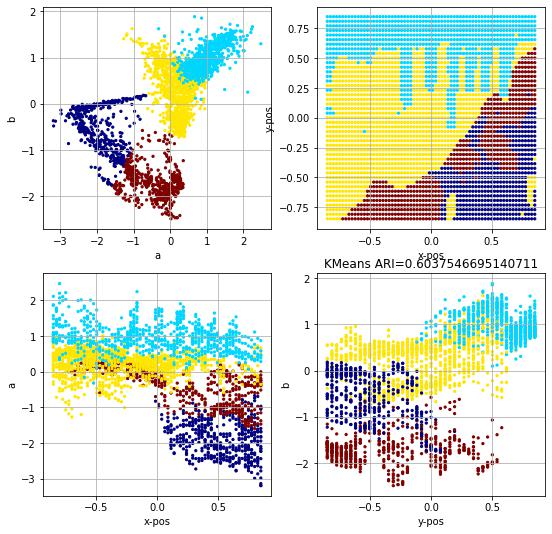

------
GaussianMixture
{'n_components': 4}


<Figure size 432x288 with 0 Axes>

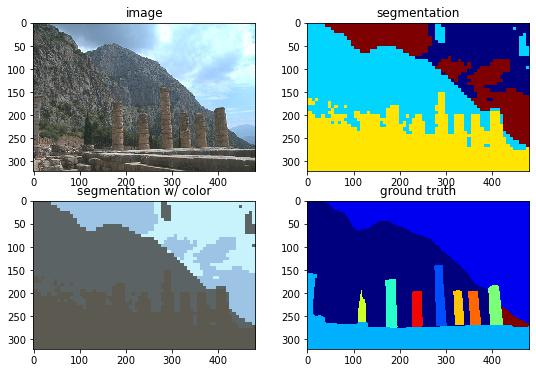

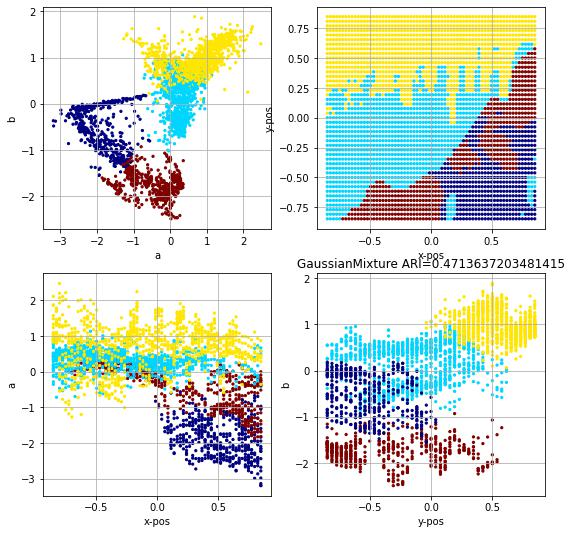

In [21]:
for L in results2:
    print('------')
    print(L['name'])
    print(L['param'])
    plt.figure()
    # show the segmentation
    showsegm(L['segm'], img)

    # show the scatter plot
    showscatter(X,L['Y'])
    plt.title(L['name'] + " ARI=" + str(L['ari']))
    plt.show()

_Which method performs the best?  Why?_
- **INSERT YOUR ANSWER HERE**

- **INSERT YOUR ANSWER HERE**
- K-means.
- K-means has higer ARI value, and the position features help to connect these shapes.

_Does including the position features improve the segmentation results?_
- **INSERT YOUR ANSWER HERE**

- **INSERT YOUR ANSWER HERE**
- Position can help to make the segmentations less noisy -- removing the spurious pixel-sized errors.